# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [31]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [32]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [33]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

df = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
print(df[['2ndFlrSF', 'BedroomAbvGr', 'SalePrice']].head())

   2ndFlrSF  BedroomAbvGr  SalePrice
0     854.0           3.0   208500.0
1       0.0           3.0   181500.0
2     866.0           3.0   223500.0
3       0.0           3.0   140000.0
4       0.0           4.0   250000.0


In [2]:
df.dtypes

1stFlrSF         float64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure      object
BsmtFinSF1       float64
BsmtFinType1      object
BsmtUnfSF        float64
EnclosedPorch    float64
GarageArea       float64
GarageFinish      object
GarageYrBlt      float64
GrLivArea        float64
KitchenQual       object
LotArea          float64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF      float64
OverallCond        int64
OverallQual        int64
TotalBsmtSF      float64
WoodDeckSF       float64
YearBuilt          int64
YearRemodAdd       int64
SalePrice        float64
dtype: object

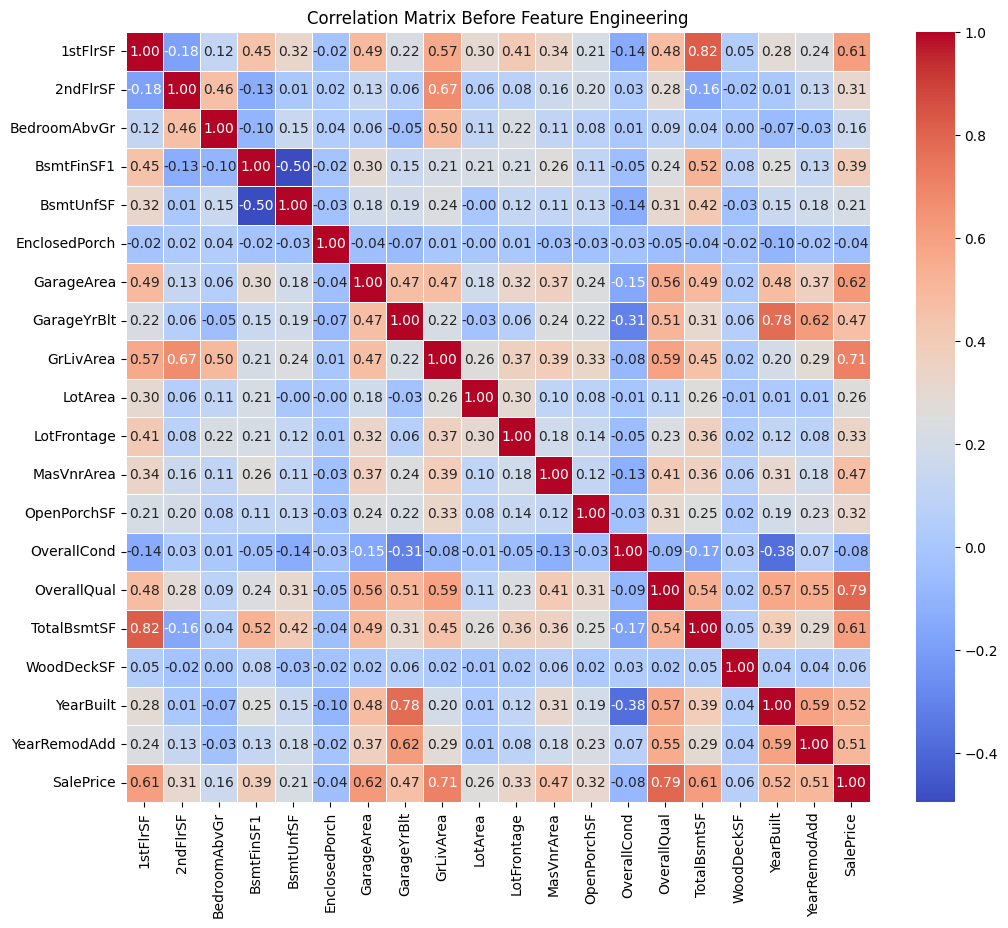

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visa korrelationsmatrisen före feature engineering
correlation_matrix_before = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Before Feature Engineering")
plt.show()


Visualize the distribution of 2ndFlrSF to see how many houses have a second floor and how large it is.
This helps identify patterns or outliers before creating new features

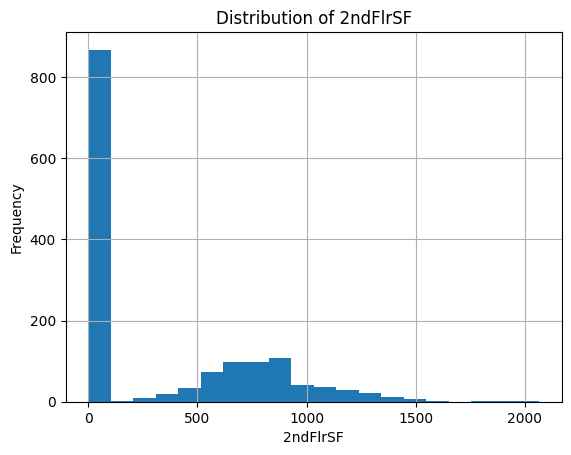

In [4]:
import matplotlib.pyplot as plt

df['2ndFlrSF'].hist(bins=20)
plt.title('Distribution of 2ndFlrSF')
plt.xlabel('2ndFlrSF')
plt.ylabel('Frequency')
plt.show()


Visualize the distribution of YearBuilt to understand the age range of houses.
This helps identify if most houses are old or new before creating the HouseAge feature

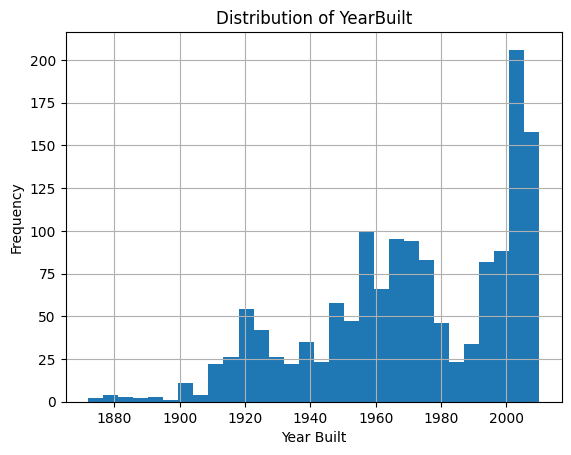

In [5]:
# Visualize the distribution of YearBuilt to see how many houses were built in different years
df['YearBuilt'].hist(bins=30)
plt.title('Distribution of YearBuilt')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.show()

**TotalSquareFootage** shows the total living space, including floors and basement.
HouseAge shows how old the house is, which may affect its price.


In [6]:
df['TotalSquareFootage'] = df['1stFlrSF'] + df['2ndFlrSF'].fillna(0) + df['TotalBsmtSF'].fillna(0)
df['HouseAge'] = 2024 - df['YearBuilt']

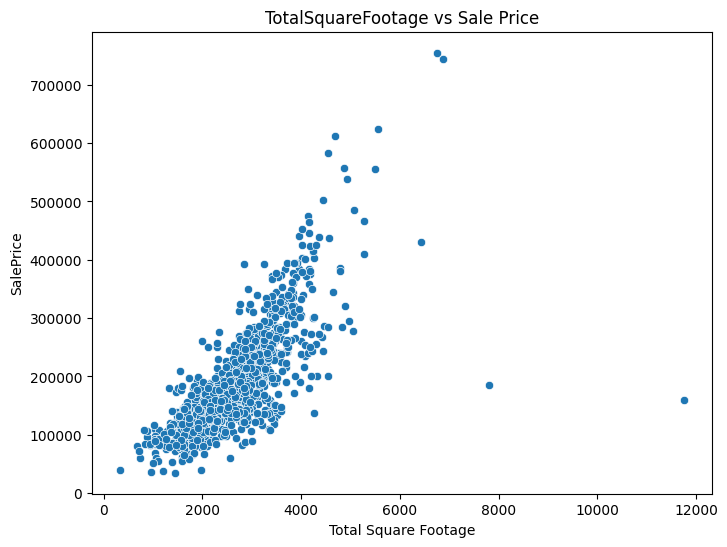

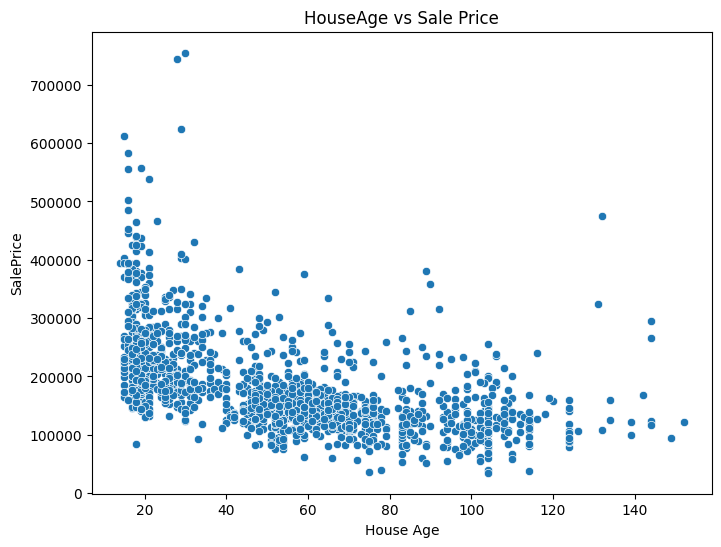

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the correlation between TotalSquareFootage and SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TotalSquareFootage', y='SalePrice', data=df)
plt.xlabel('Total Square Footage')
plt.ylabel('SalePrice')
plt.title('TotalSquareFootage vs Sale Price')
plt.show()

# Visualize the correlation between HouseAge and SalePrice
plt.figure(figsize=(8, 6))
sns.scatterplot(x='HouseAge', y='SalePrice', data=df)
plt.xlabel('House Age')
plt.ylabel('SalePrice')
plt.title('HouseAge vs Sale Price')
plt.show()

* The scatter plot shows a strong positive relationship between total square footage and sale price, as expected. Larger houses usually have higher sale prices. This confirms that total living space is an important predictor of house value, and including this feature should help improve model accuracy.
* The scatter plot shows that older houses tend to have lower sale prices, while newer houses sell for more. This suggests that house age has a big effect on property value.*

___

In [8]:
# Categorical and numerical columns
categorical_columns = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']
numerical_columns = ['2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'GrLivArea', 'TotalSquareFootage', 'HouseAge']
X_numerical = df[numerical_columns]

In [9]:
# Used one-hot encoding for categories
X_categorical = df[categorical_columns]
X_categorical_encoded = pd.get_dummies(X_categorical)

# Changed boolean columns to 0 and 1
X_categorical_encoded = X_categorical_encoded.astype(int)

# Combined numbers and encoded categories
X_combined = pd.concat([X_numerical, X_categorical_encoded], axis=1)

# Create a pipeline to scale numbers
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

try:
    # Apply the pipeline to scale numerical features
    X_combined[numerical_columns] = pipeline.fit_transform(X_combined[numerical_columns])

    # Included SalePrice in transformed data
    X_combined['SalePrice'] = df['SalePrice']

    # Changed boolean columns to integers
    bool_columns = X_combined.select_dtypes(include=['bool']).columns
    X_combined[bool_columns] = X_combined[bool_columns].astype(int)

    # Display information about the transformed dataset
    print("Transformed dataset size:", X_combined.shape)
    print(X_combined.head())

    # Confirm the data types after all transformations
    print(X_combined.dtypes)

except Exception as e:
    print("Error during pipeline execution:", e)


Transformed dataset size: (1460, 25)
   2ndFlrSF  BedroomAbvGr  BsmtFinSF1  GarageArea  GrLivArea  \
0  1.213595      0.153895    0.575425    0.351000   0.370333   
1 -0.756746      0.153895    1.171992   -0.060731  -0.482512   
2  1.241281      0.153895    0.092907    0.631726   0.515013   
3 -0.756746      0.153895   -0.499274    0.790804   0.383659   
4 -0.756746      1.416182    0.463568    1.698485   1.299326   

   TotalSquareFootage  HouseAge  BsmtExposure_Av  BsmtExposure_Gd  \
0            0.021700 -1.050994                0                0   
1           -0.029076 -0.156734                0                1   
2            0.190955 -0.984752                0                0   
3           -1.004708  1.863632                0                0   
4           -0.311973 -0.951632                1                0   

   BsmtExposure_Mn  ...  BsmtFinType1_Rec  BsmtFinType1_Unf  GarageFinish_Fin  \
0                0  ...                 0                 0                 0   
1

Check for missing values after one-hot encoding

In [10]:
missing_values_after_encoding = X_categorical_encoded.isnull().sum()
print("Missing values after one-hot encoding:")
print(missing_values_after_encoding[missing_values_after_encoding > 0])

Missing values after one-hot encoding:
Series([], dtype: int64)


 No missing values found in categorical columns after one-hot encoding

___

Visualize the distribution of 2ndFlrSF to see how many houses have a second floor and its size


In [11]:
print("Missing values in numerical columns:")
print(df[numerical_columns].isnull().sum())

Missing values in numerical columns:
2ndFlrSF              0
BedroomAbvGr          0
BsmtFinSF1            0
GarageArea            0
GrLivArea             0
TotalSquareFootage    0
HouseAge              0
dtype: int64


In [12]:
print("DataFrame shape after operation:", df.shape)
print("DataFrame columns after operation:", df.columns.tolist())

DataFrame shape after operation: (1460, 26)
DataFrame columns after operation: ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinType1', 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageFinish', 'GarageYrBlt', 'GrLivArea', 'KitchenQual', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallCond', 'OverallQual', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'SalePrice', 'TotalSquareFootage', 'HouseAge']


Show correlation matrix for numeric features

In [13]:
correlation_matrix = df.select_dtypes(include=['float64', 'int64']).corr()

Create a heatmap to visualize the correlation matrix

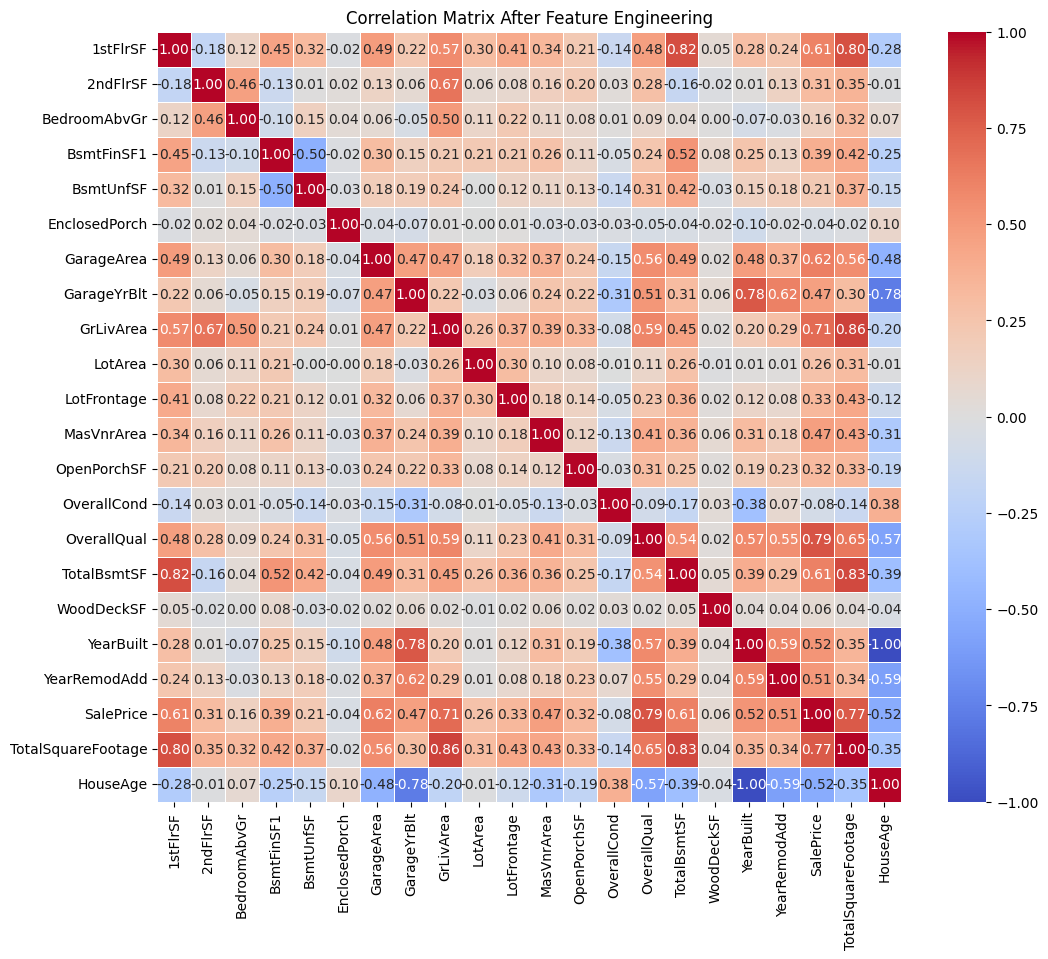

In [14]:

correlation_matrix_after = df.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_after, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix After Feature Engineering")
plt.show()



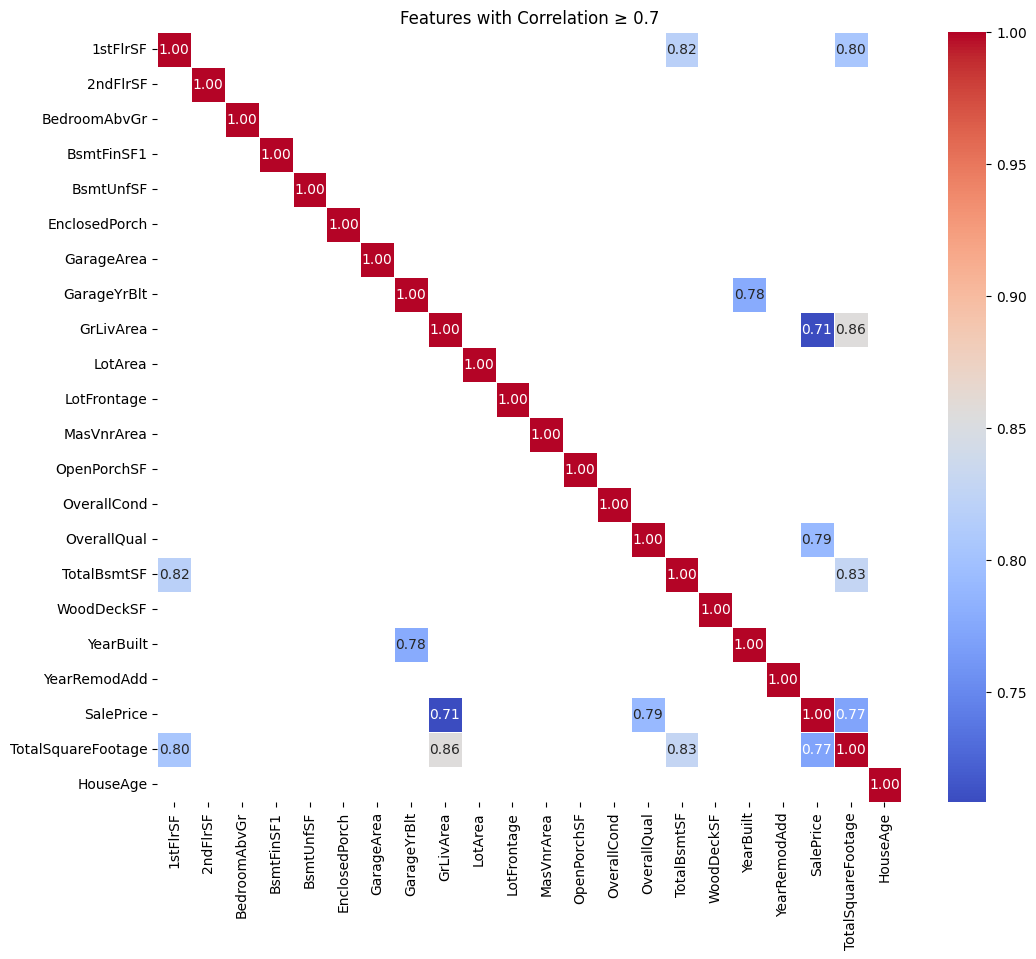

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Threshold for high correlation
threshold = 0.7

# Filter correlation matrix to keep values >= 0.8
high_correlation = correlation_matrix.applymap(lambda x: x if x >= threshold else np.nan)

# Plot the filtered correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(high_correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Features with Correlation ≥ 0.7")
plt.show()


In [16]:
# Filter high correlation features related to SalePrice
high_corr_with_target = correlation_matrix['SalePrice'][correlation_matrix['SalePrice'] >= threshold]
print("Features with high correlation to SalePrice:", high_corr_with_target)

Features with high correlation to SalePrice: GrLivArea             0.708624
OverallQual           0.790982
SalePrice             1.000000
TotalSquareFootage    0.772116
Name: SalePrice, dtype: float64


### Hypothesis 1 Confirmed
The scatter plots and correlation analysis show a positive relationship between the total area of the house and its sale price, confirming our initial hypothesis that bigger houses tend to have higher sale prices.

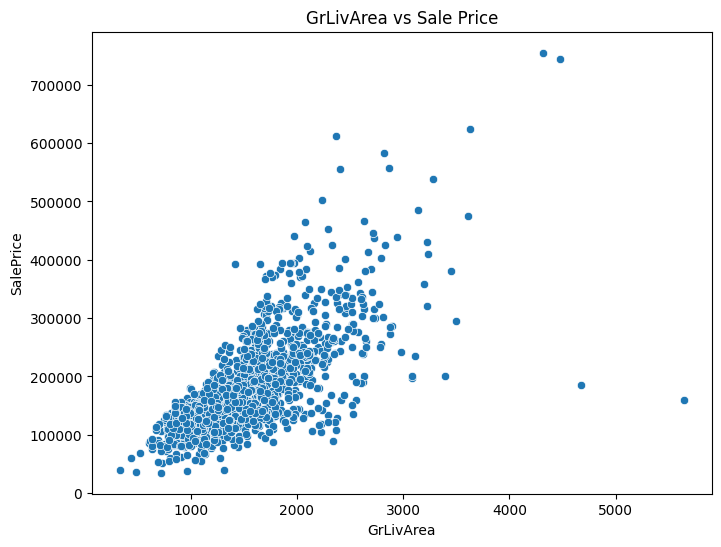

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs Sale Price')
plt.show()

### Hypothesis 2 Confirmed
* The scatter plot and correlation analysis show a strong positive link between OverallQual and SalePrice. With a correlation of 0.79, higher quality homes tend to sell for more. This confirms that home quality affects its sale price.

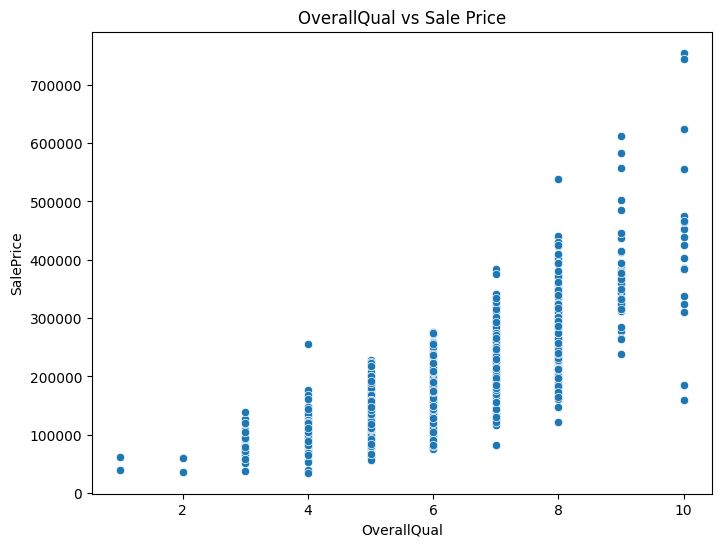

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=df)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('OverallQual vs Sale Price')
plt.show()

### Hypothesis 3 Confirmed
The scatter plot and correlation analysis show a positive relationship between 'GarageArea' and 'SalePrice'. This confirms the hypothesis that houses with bigger garages tend to sell for higher prices.

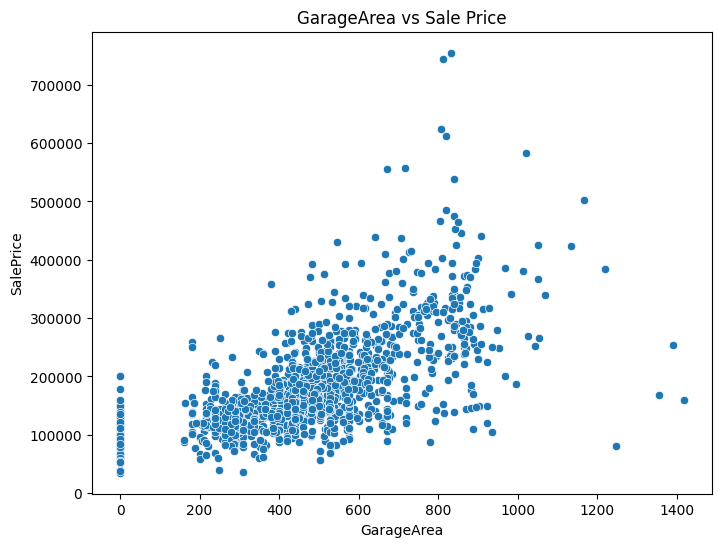

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GarageArea', y='SalePrice', data=df)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.title('GarageArea vs Sale Price')
plt.show()

In [20]:
print(X_combined.dtypes)

2ndFlrSF              float64
BedroomAbvGr          float64
BsmtFinSF1            float64
GarageArea            float64
GrLivArea             float64
TotalSquareFootage    float64
HouseAge              float64
BsmtExposure_Av         int64
BsmtExposure_Gd         int64
BsmtExposure_Mn         int64
BsmtExposure_No         int64
BsmtFinType1_ALQ        int64
BsmtFinType1_BLQ        int64
BsmtFinType1_GLQ        int64
BsmtFinType1_LwQ        int64
BsmtFinType1_Rec        int64
BsmtFinType1_Unf        int64
GarageFinish_Fin        int64
GarageFinish_RFn        int64
GarageFinish_Unf        int64
KitchenQual_Ex          int64
KitchenQual_Fa          int64
KitchenQual_Gd          int64
KitchenQual_TA          int64
SalePrice             float64
dtype: object


Print the number of unique values in each column

In [21]:
print(df.nunique())
print(df['SalePrice'].unique())

1stFlrSF               753
2ndFlrSF               401
BedroomAbvGr             8
BsmtExposure             4
BsmtFinSF1             637
BsmtFinType1             6
BsmtUnfSF              780
EnclosedPorch           19
GarageArea             441
GarageFinish             3
GarageYrBlt             97
GrLivArea              861
KitchenQual              4
LotArea               1073
LotFrontage            110
MasVnrArea             327
OpenPorchSF            202
OverallCond              9
OverallQual             10
TotalBsmtSF            721
WoodDeckSF              58
YearBuilt              112
YearRemodAdd            61
SalePrice              663
TotalSquareFootage     964
HouseAge               112
dtype: int64
[208500. 181500. 223500. 140000. 250000. 143000. 307000. 200000. 129900.
 118000. 129500. 345000. 144000. 279500. 157000. 132000. 149000.  90000.
 159000. 139000. 325300. 139400. 230000. 154000. 256300. 134800. 306000.
 207500.  68500.  40000. 149350. 179900. 165500. 277500. 309000. 1

___

## Push files to repo

In [18]:
X_combined.to_csv("outputs/datasets/collection/HousePricesFeatures.csv", index=False)
print("Exported the transformed dataset successfully!")

Exported the transformed dataset successfully!
